# Project: Identify Customer Segments

In this project, we will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from time import time
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, Imputer, StandardScaler
from sklearn.base import  BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from scipy import sparse
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import helper_functions
from helper_functions import CategoricalEncoder, return_decade, return_movement
import random
import pickle
# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. We will use this information to cluster the general population into groups with similar demographic properties. Then, we will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, we will load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so we'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

In [4]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',delimiter=';')

In [5]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [6]:
number_obs, number_cols = azdias.shape

In [7]:
print('Number of observations: {}'.format(number_obs))
print('Number of fields: {}'.format(number_cols))

Number of observations: 891221
Number of fields: 85


In [8]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [9]:
azdias.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [10]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. We will use this file to help us make cleaning decisions during this stage of the project. First of all, we will assess the demographics data in terms of missing data. 

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. We''ll need to do a little bit of parsing to make use of it to identify and clean the data. We'll convert the data that matches a 'missing' or 'unknown' value code into a numpy NaN value. 

In [11]:
# Identify missing or unknown data values and convert them to NaNs.
perc_naturally_missing = azdias.isnull().sum()/number_obs*100

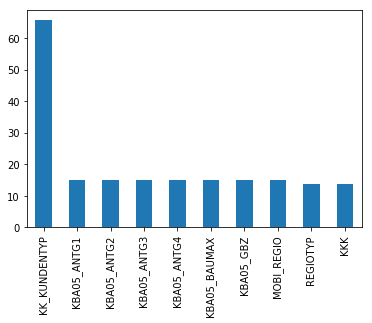

In [12]:
# Plot the top 10 features with the most missing values
top_10_missing = perc_naturally_missing.sort_values(axis=0,ascending=False)[:10]
top_10_missing.plot(kind='bar')

In [13]:
# Create a copy of the original dataset to do transformations on
azdias_with_missing = azdias.copy()

In [14]:
feat_info[feat_info['type'] == 'mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [15]:
feat_info[feat_info['attribute'] == 'CAMEO_INTL_2015'] 

,attribute,information_level,type,missing_or_unknown
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"


In [16]:
# Identifying unknown and missing data values and convert them to NaNs 
azdias_with_missing = helper_functions.convert_missing_values(azdias_with_missing,feat_info)

Replacing: AGER_TYP
Replacing: ALTERSKATEGORIE_GROB
Replacing: ANREDE_KZ
Replacing: CJT_GESAMTTYP
Replacing: FINANZ_MINIMALIST
Replacing: FINANZ_SPARER
Replacing: FINANZ_VORSORGER
Replacing: FINANZ_ANLEGER
Replacing: FINANZ_UNAUFFAELLIGER
Replacing: FINANZ_HAUSBAUER
Replacing: FINANZTYP
Replacing: GEBURTSJAHR
Replacing: GFK_URLAUBERTYP
Replacing: GREEN_AVANTGARDE
Replacing: HEALTH_TYP
Replacing: LP_LEBENSPHASE_FEIN
Replacing: LP_LEBENSPHASE_GROB
Replacing: LP_FAMILIE_FEIN
Replacing: LP_FAMILIE_GROB
Replacing: LP_STATUS_FEIN
Replacing: LP_STATUS_GROB
Replacing: NATIONALITAET_KZ
Replacing: PRAEGENDE_JUGENDJAHRE
Replacing: RETOURTYP_BK_S
Replacing: SEMIO_SOZ
Replacing: SEMIO_FAM
Replacing: SEMIO_REL
Replacing: SEMIO_MAT
Replacing: SEMIO_VERT
Replacing: SEMIO_LUST
Replacing: SEMIO_ERL
Replacing: SEMIO_KULT
Replacing: SEMIO_RAT
Replacing: SEMIO_KRIT
Replacing: SEMIO_DOM
Replacing: SEMIO_KAEM
Replacing: SEMIO_PFLICHT
Replacing: SEMIO_TRADV
Replacing: SHOPPER_TYP
Replacing: SOHO_KZ
Replacing:

In [17]:
azdias_with_missing.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [18]:
azdias['AGER_TYP'].value_counts(dropna=False)

-1    677503
 2     98472
 1     79802
 3     27104
 0      8340
Name: AGER_TYP, dtype: int64

In [19]:
azdias_with_missing['AGER_TYP'].value_counts(dropna=False)

NaN     685843
 2.0     98472
 1.0     79802
 3.0     27104
Name: AGER_TYP, dtype: int64

#### Step 1.1.2: Assess Missing Data in Each Column

Next, we want to see how much missing data is present in each column. 

In [20]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
num_missing_col = azdias_with_missing.isnull().sum(axis=0)
perc_missing_col = num_missing_col/number_obs*100

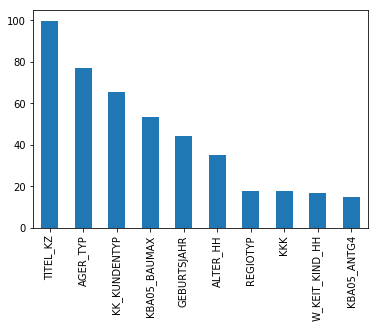

In [21]:
# Plot the top 10 features with the most missing values
top_10_missing = perc_missing_col.sort_values(axis=0,ascending=False)[:10]
top_10_missing.plot(kind='bar')

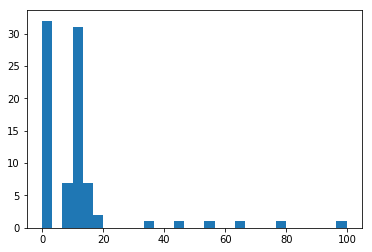

In [22]:
#Visualize the distribution of missing values
plt.hist(perc_missing_col,bins=30)
plt.show()

In [23]:
# Investigate patterns in the amount of missing data in each column.
fields = azdias_with_missing.columns.tolist()
cross_tab_missing = np.zeros(shape=(number_cols,number_cols))
miss_value_indicator = azdias_with_missing.isnull()

First we'll draw up a matrix of the number of times different combination of features are 
missing for a particular row (person). We only need to populate the lower triangle of the matrix, 
since it's a symmetric matrix. We therefor save a lot of computational time 

In [24]:
start_time = time()
for i in range(number_cols):
    for j in range(number_cols):
        if j <= i:
            cross_tab_missing[i,j] = np.sum(miss_value_indicator.iloc[:,i] & miss_value_indicator.iloc[:,j])
print('Time to calculate: {}'.format(time()-start_time))

Time to calculate: 45.64220881462097


In [25]:
cross_tab_missing = cross_tab_missing/number_obs

Next we can make use of the heatmap plot in the Seaborn library. We can mask the upper triangle of the matrix, since
it won't add value

In [26]:
mask = np.zeros_like(cross_tab_missing)
for i in range(number_cols):
    for j in range(number_cols):
        if j > i:
            mask[i,j] = True
            


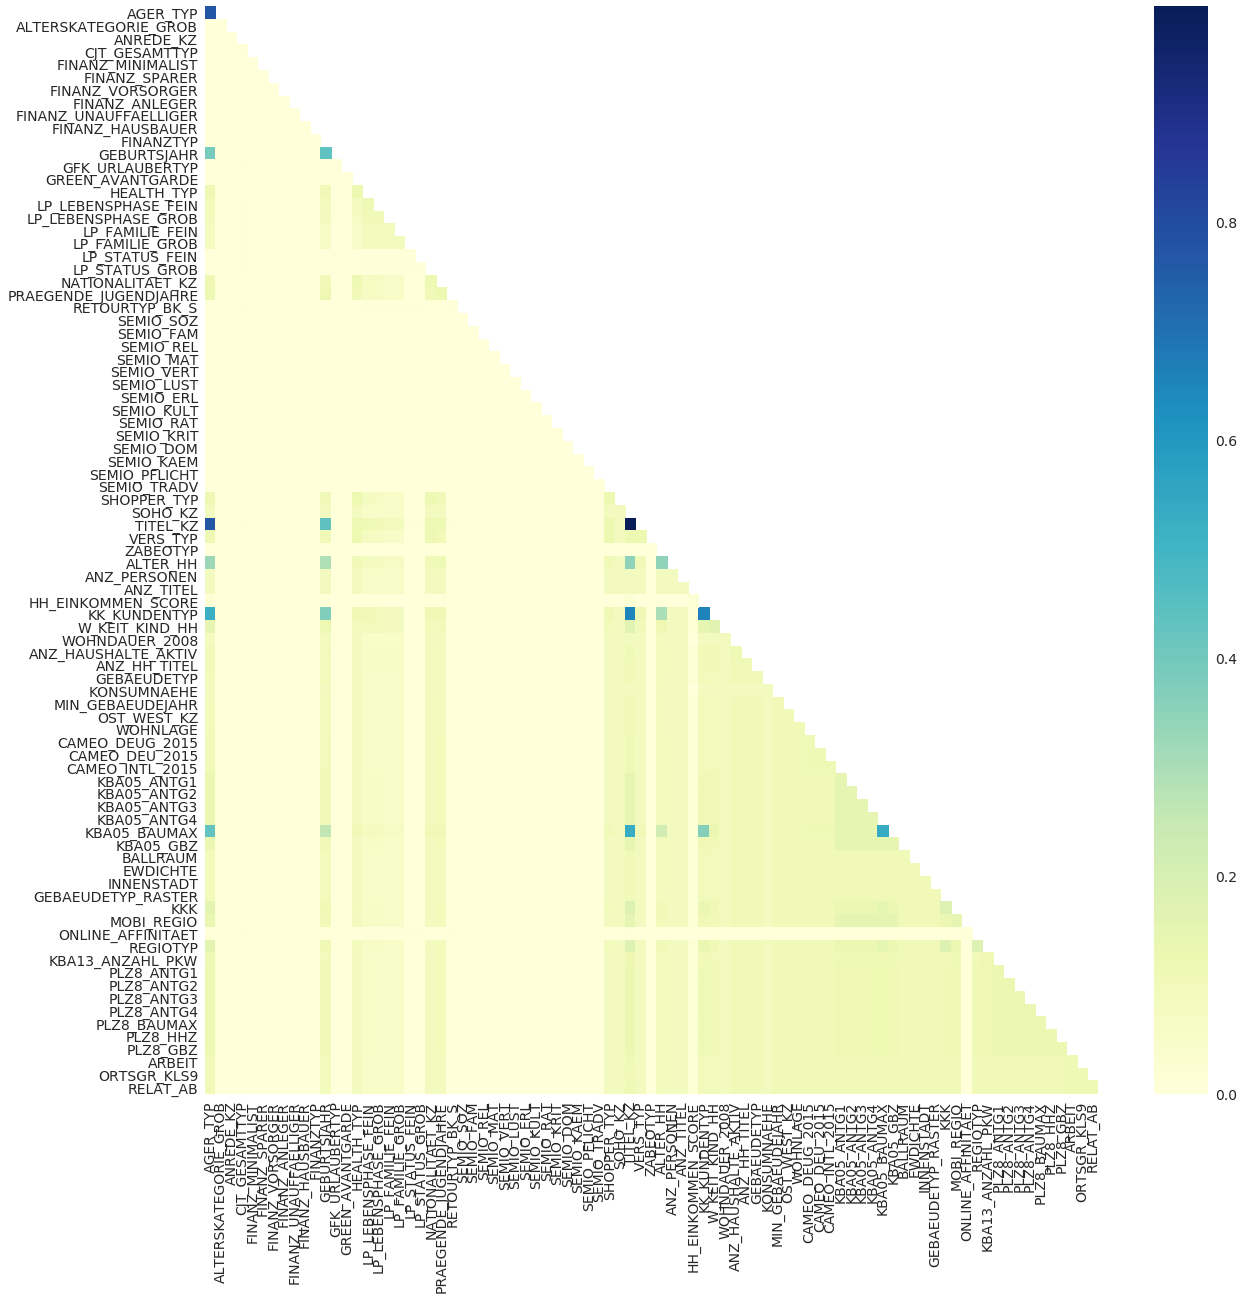

In [27]:
sns.set(font_scale=1.4)
fig, ax = plt.subplots()
ax.set(facecolor='white')
fig.set_size_inches(20, 20)
ax=sns.heatmap(cross_tab_missing,xticklabels=fields,yticklabels=fields,mask=mask,cmap="YlGnBu")

In [28]:
# Remove the outlier columns from the dataset. 
missing_value_cutoff = 20
remove_vars = perc_missing_col[perc_missing_col > missing_value_cutoff].index

In [29]:
remove_vars

Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')

In [30]:
azdias_with_missing_removed = azdias_with_missing.drop(remove_vars,axis=1)

#### Discussion 1.1.2: Assess Missing Data in Each Column
By looking at naturally occurring missing values, we see that the column with the most amount of missing values is the KK_KUNDENTYP column (Consumer pattern over past 12 months). Around 70% of this column has missing values. This is probably to be expected, since this field is only applicable to the company's customer base.
After replacing unknown and missing values codes with missing values, we see that the column with the most amount of missing values is now TITEL_KZ (Academic title flag) with almost 100% missing values, followed by AGER_TYP (Best-ager typology) with around 80% of the values missing.
The heatmap plot gives us an idea of the combination of columns that are missing at the same time. If AGER_TYP, GEBURTSJAHR, TITEL_KZ, ALTER_HH, KK_KUNDENTYP or KBA05_BAUMAX is missing the other also tend to be missing.
Based on the histogram of the percent missing values per column, we decided on a cut-off value of 20% for missing values- there is a clear separation between fields with 20% and fewer missing values and those with more than 20% missing values.
The following columns were therefore removed:

* AGER_TYP
* GEBURTSJAHR
* TITEL_KZ
* ALTER_HH
* KK_KUNDENTYP
* KBA05_BAUMAX

#### Step 1.1.3: Assess Missing Data in Each Row

Now, we'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, we should see some groups of points that have a very different numbers of missing values. 

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. 

Depending on what we observe in our comparison, this will have implications on how we approach our conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. 

In [31]:
# How much data is missing in each row of the dataset?
number_cols = azdias_with_missing_removed.shape[1]
num_missing_row = azdias_with_missing_removed.isnull().sum(axis=1)
perc_missing_row = num_missing_row/number_cols*100

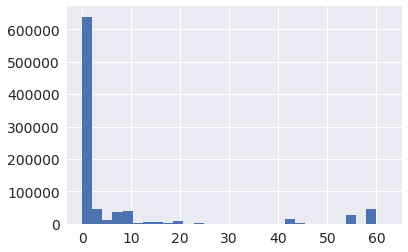

In [32]:
# Plotting histogram of percent missing values per row
plt.hist(perc_missing_row,bins=30)
plt.show()

In [33]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

threshold_missing = 20
azdias_with_missing_removed['Has_missing'] = perc_missing_row.map(lambda x: 'Yes' if x > threshold_missing else 'No')
rows_to_drop = perc_missing_row[perc_missing_row > threshold_missing].index


In [34]:
azdias_with_missing_removed['Has_missing'].value_counts()

No     792287
Yes     98934
Name: Has_missing, dtype: int64

In [35]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

col_no_missing_values = perc_missing_col[perc_missing_col==0].index

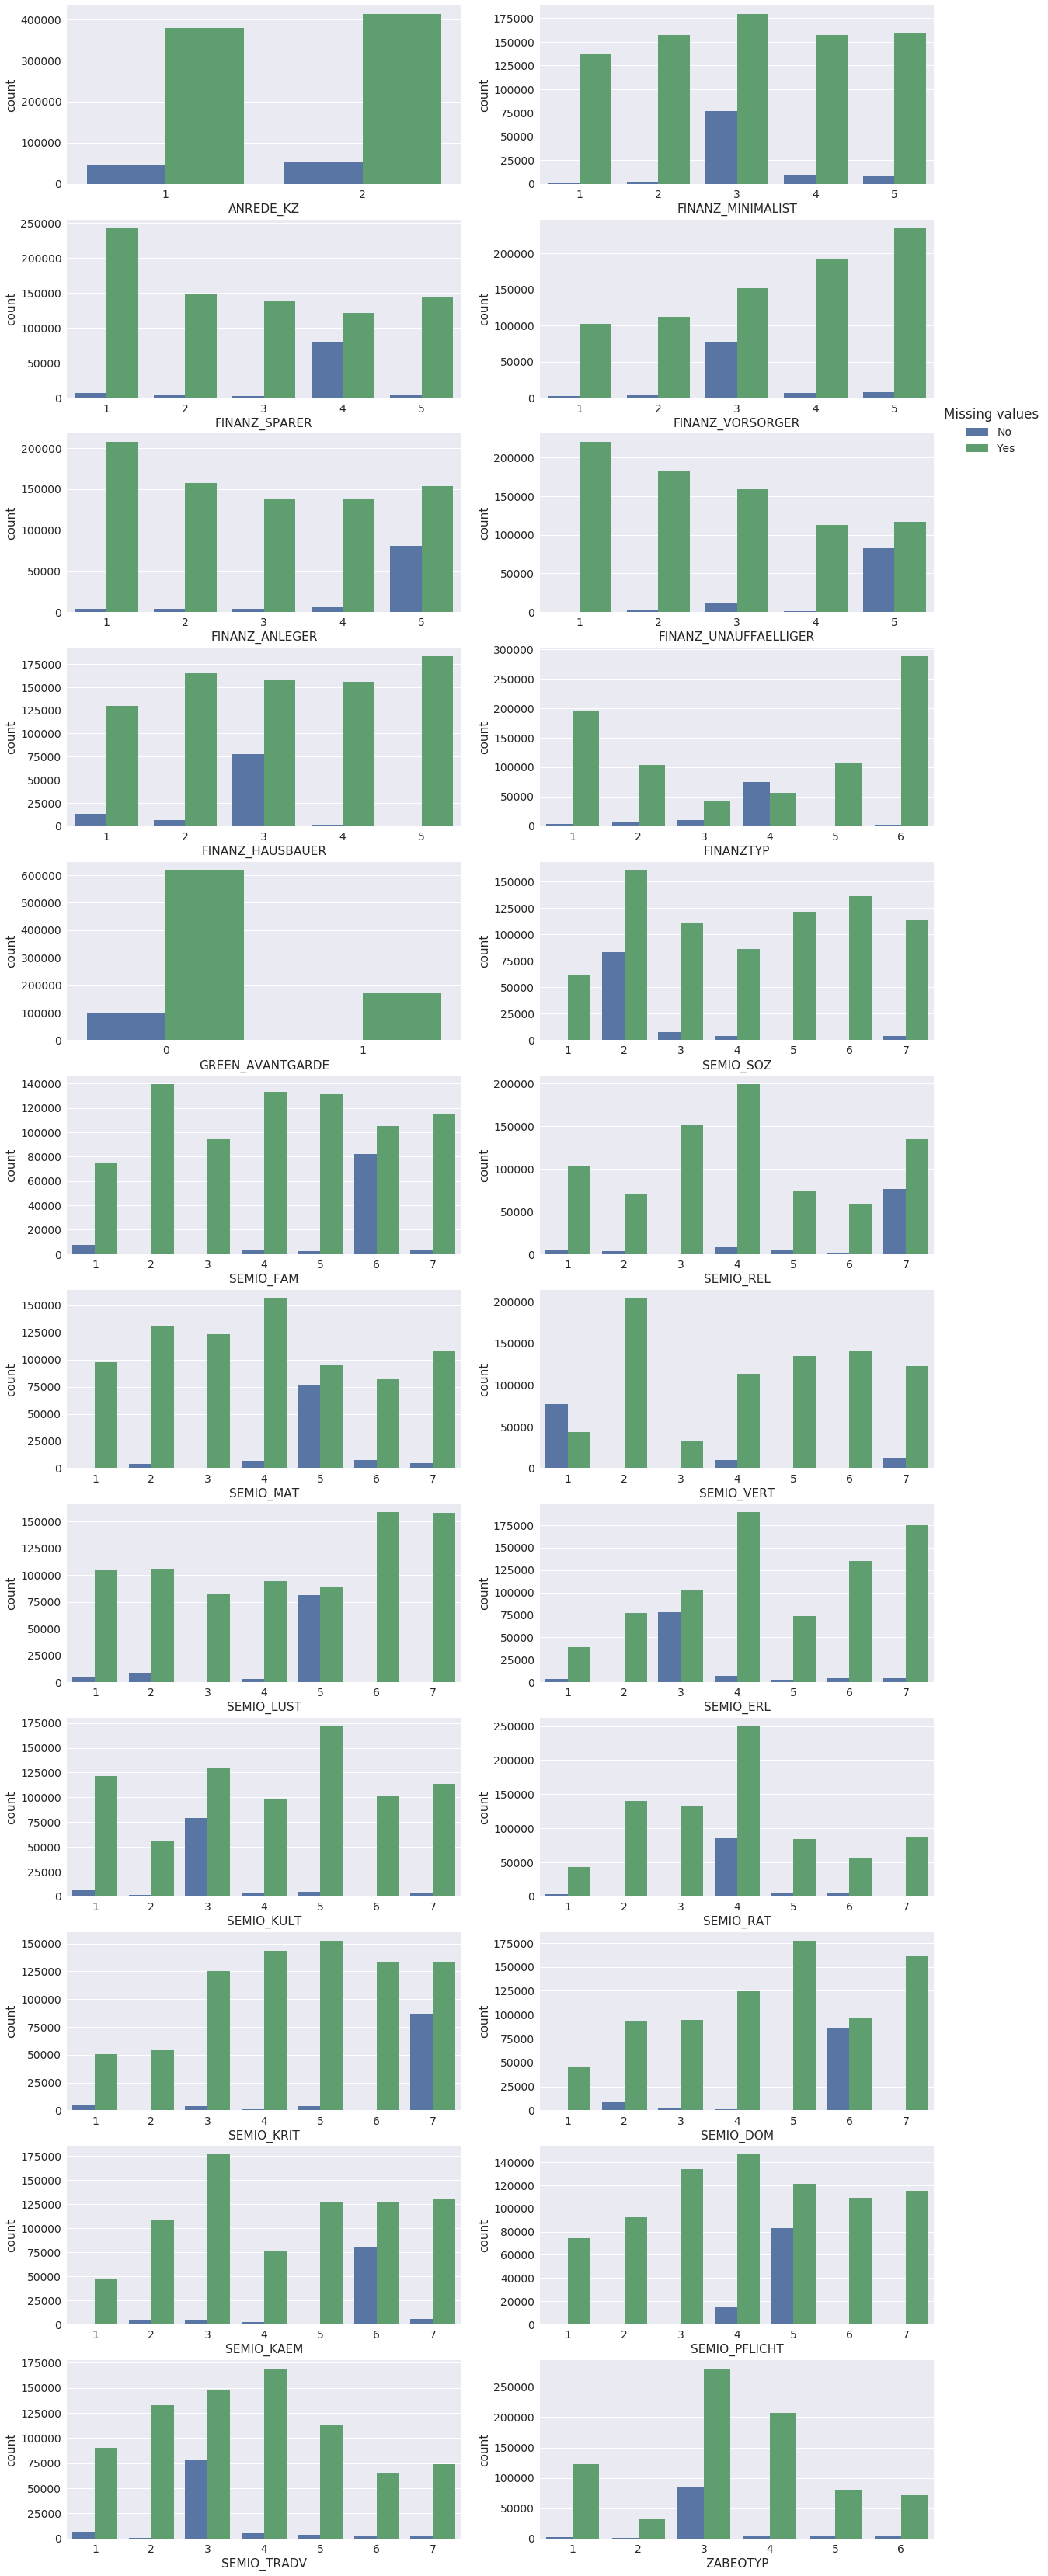

In [36]:
helper_functions.plot_comparisons(azdias_with_missing_removed,col_no_missing_values)

In [37]:
azdias_subset = (azdias_with_missing_removed[azdias_with_missing_removed['Has_missing']=='No']
                 .drop('Has_missing',axis=1).reset_index(drop=True))

#### Discussion 1.1.3: Assess Missing Data in Each Row

From the histogram we saw that the vast majority of the rows contained few to no missing values. The was however some outlier rows in terms of missing values that was easily identified from the plot. A cut-off value of 20% was decided on and when comparing the distributions of non-missing features between the rows with few to no missing values and the rows with more than 20% missing values, we saw that the distributions were quite dissimilar- except in the case of gender (ANREDE_KZ). We however still dropped all rows with more than 20% missing values. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, we need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, we will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether we will keep, drop, or re-encode each. Then, in the last part, we will create a new data frame with only the selected and engineered columns.

In [38]:
# How many features are there of each data type?
feat_info['type'].value_counts()


ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [39]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical_vars = feat_info.loc[feat_info['type'] =='categorical','attribute']

for col in categorical_vars:
    if col not in remove_vars:
        
        value_counts = azdias_subset[col].value_counts()
        number_categories = len(value_counts)
        
        print('Variable: '+col+ '\n---------------------------')
        print('Number of categories: {}'.format(number_categories))
        
        if number_categories == 2:
              print('Binary values: {}'.format(value_counts.index))
              
        print('')

Variable: ANREDE_KZ
---------------------------
Number of categories: 2
Binary values: Int64Index([2, 1], dtype='int64')

Variable: CJT_GESAMTTYP
---------------------------
Number of categories: 6

Variable: FINANZTYP
---------------------------
Number of categories: 6

Variable: GFK_URLAUBERTYP
---------------------------
Number of categories: 12

Variable: GREEN_AVANTGARDE
---------------------------
Number of categories: 2
Binary values: Int64Index([0, 1], dtype='int64')

Variable: LP_FAMILIE_FEIN
---------------------------
Number of categories: 11

Variable: LP_FAMILIE_GROB
---------------------------
Number of categories: 5

Variable: LP_STATUS_FEIN
---------------------------
Number of categories: 10

Variable: LP_STATUS_GROB
---------------------------
Number of categories: 5

Variable: NATIONALITAET_KZ
---------------------------
Number of categories: 3

Variable: SHOPPER_TYP
---------------------------
Number of categories: 4

Variable: SOHO_KZ
---------------------------
Nu

In [40]:
# Re-encode categorical variable(s) to be kept in the analysis.
# Will be done in later step

var_to_be_included1 = ['ANREDE_KZ',
'CJT_GESAMTTYP',
'FINANZTYP',
'GFK_URLAUBERTYP',
'LP_FAMILIE_GROB',
'LP_STATUS_GROB',
'NATIONALITAET_KZ',
'SHOPPER_TYP',
'SOHO_KZ',
'VERS_TYP',
'ZABEOTYP',
'OST_WEST_KZ',
'CAMEO_DEUG_2015']


#### Discussion 1.2.1: Re-Encode Categorical Features

After evaluating the number of categories for each feature and looking at the data dictionary, it was decided to keep the following features:
* ANREDE_KZ
* CJT_GESAMTTYP
* FINANZTYP
* GFK_URLAUBERTYP
* LP_FAMILIE_GROB
* LP_STATUS_GROB
* NATIONALITAET_KZ
* SHOPPER_TYP
* SOHO_KZ
* VERS_TYP
* ZABEOTYP
* OST_WEST_KZ
* CAMEO_DEUG_2015

and to drop the following features:
* LP_FAMILIE_FEIN
* LP_STATUS_FEIN
* GEBAEUDETYP
* CAMEO_DEU_2015

The reason why these features were dropped is because they are more granular versions of features that were kept (LP_FAMILIE_FEIN, LP_STATUS_FEIN,CAMEO_DEU_2015) or it was felt that they will not add any value to the analysis (GEBAEUDETYP). The one-hot encoding of the variables that were kept will happen in the next step.


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, we will create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. We will break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

In [41]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_subset['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    181525
8.0     140681
10.0     85276
5.0      84400
3.0      53615
15.0     42078
11.0     35448
9.0      33515
6.0      25629
12.0     24340
1.0      20550
4.0      20431
2.0       7470
13.0      5714
7.0       4000
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [42]:
azdias_subset['DECADE'] = azdias_subset['PRAEGENDE_JUGENDJAHRE'].apply(return_decade)
azdias_subset['MAINSTREAM'] = azdias_subset['PRAEGENDE_JUGENDJAHRE'].apply(return_movement)

In [43]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_subset['CAMEO_INTL_2015'].value_counts()

51    133492
41     92080
24     90699
14     62565
43     56495
54     45287
25     39413
22     32931
13     26162
45     26038
23     26028
55     23866
52     20508
31     18661
34     18445
15     16913
44     14776
12     13136
35     10316
32     10304
33      9856
Name: CAMEO_INTL_2015, dtype: int64

In [44]:
azdias_subset['WEALTH'] = azdias_subset['CAMEO_INTL_2015'].astype(float)  // 10
azdias_subset['LIFESTAGE'] = azdias_subset['CAMEO_INTL_2015'].astype(float)  % 10

In [45]:
feat_info[feat_info['type'] == 'mixed'] 

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [46]:
var_to_be_included2 = ['LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX']

We'll make use of the following function to do the one-hot encoding on the categorical and mixed fields.This is a Scikit-learn function that is still in development and not part of the latest Scikit-learn release.  The source code can be found [here](https://github.com/scikit-learn/scikit-learn/blob/34155a2/sklearn/preprocessing/data.py#L2869)

In [47]:
variables_to_be_encoded = var_to_be_included1 + var_to_be_included2

In [48]:
cat_encoder = helper_functions.CategoricalEncoder(encoding="onehot-dense")
categorical_one_hot_enc = cat_encoder.fit(azdias_subset[variables_to_be_encoded].astype(str))
categorical_one_hot = categorical_one_hot_enc.transform(azdias_subset[variables_to_be_encoded].astype(str)) 

In [49]:
#We'll save the one-hot encoding method as a pickle file to be used in later steps

with open('categorical_one_hot_enc.pkl', 'wb') as output: 
    pickle.dump(categorical_one_hot_enc,output)   

#### Discussion 1.2.2: Engineer Mixed-Type Features

There was a total of 7 mixed type variables, of which two were used to create 4 new features. The rest were encoded (together with the categorical variables that were kept in the previous step) using one-hot encoding. The following feature was however not encoded and will be drop in a later step:

* LP_LEBENSPHASE_FEIN




#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, we need to make sure that our data frame now only has the columns that we want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

In [50]:
drop_variables = ['LP_LEBENSPHASE_FEIN','CAMEO_INTL_2015','PRAEGENDE_JUGENDJAHRE','LP_FAMILIE_FEIN','LP_STATUS_FEIN',
                 'CAMEO_DEU_2015','GEBAEUDETYP'] + variables_to_be_encoded


In [51]:
dummy_column_names = []
for col, values in zip(variables_to_be_encoded,categorical_one_hot_enc.categories_):
    dummy_column_names += [(col+"_"+str(i)) for i in values]
    

In [52]:
dummy_df = pd.DataFrame(categorical_one_hot,columns=dummy_column_names)

In [53]:
final_df = pd.concat([azdias_subset.drop(drop_variables,axis=1),dummy_df],axis=1)

In [54]:
final_df.shape

(792287, 159)

In [55]:
azdias_subset.loc[:,drop_variables].head()

,LP_LEBENSPHASE_FEIN,CAMEO_INTL_2015,PRAEGENDE_JUGENDJAHRE,LP_FAMILIE_FEIN,LP_STATUS_FEIN,CAMEO_DEU_2015,GEBAEUDETYP,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,...,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,OST_WEST_KZ,CAMEO_DEUG_2015,LP_LEBENSPHASE_GROB,WOHNLAGE,PLZ8_BAUMAX
0,21.0,51,14.0,5.0,2.0,8A,8.0,2,5.0,1,...,1.0,3.0,1.0,2.0,5,W,8,6.0,4.0,1.0
1,3.0,24,15.0,1.0,3.0,4C,1.0,2,3.0,1,...,1.0,2.0,0.0,1.0,5,W,4,1.0,2.0,1.0
2,NaN,12,8.0,NaN,9.0,2A,1.0,2,2.0,6,...,1.0,1.0,0.0,1.0,3,W,2,NaN,7.0,1.0
3,32.0,43,8.0,10.0,3.0,6B,1.0,1,5.0,5,...,1.0,2.0,0.0,2.0,4,W,6,10.0,3.0,2.0
4,8.0,54,3.0,1.0,4.0,8C,1.0,2,2.0,2,...,1.0,0.0,0.0,2.0,4,W,8,2.0,7.0,1.0


In [56]:
final_df.loc[:,dummy_column_names].head()

,ANREDE_KZ_1,ANREDE_KZ_2,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,CJT_GESAMTTYP_nan,FINANZTYP_1,...,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0,PLZ8_BAUMAX_nan
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. 

In [57]:
means = final_df.mean(axis=0,skipna=True)
stdevs = final_df.std(axis=0,skipna=True)

In [58]:
# We'll write the means and standard deviations to a csv file so it can be used to scale the customer data

means.to_csv('means.csv')
stdevs.to_csv('stdevs.csv')           

In [59]:
# Apply feature scaling to the general population demographics data.
rescaled_data = helper_functions.scale_impute_colums(final_df,means,stdevs)

### Discussion 2.1: Apply Feature Scaling

We calculated the mean and standard deviation of all the features before we imputed the missing values. The missing values were imputed with these mean values. There are of course more advanced techniques that can be used to impute variables, but we decided to keep it simple. The data was scaled using the mean and standard deviations that were calculated before imputation. This is to ensure that the imputed values don't introduce further bias when scaling. The mean and standard deviations were saved and a scaling function was created to be used on the customer data

### Step 2.2: Perform Dimensionality Reduction

On our scaled data, we are now ready to apply dimensionality reduction techniques. We'll make use of sklearn's PCA method class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, we will not set any parameters (so all components are computed).

We will check out the ratio of variance explained by each principal component as well as the cumulative variance explained to make a decision on how many pricipal components te retain.

In [ ]:
# Apply PCA to the data.
prin_comp = PCA().fit(rescaled_data)

In [ ]:
# Investigate the variance accounted for by each principal component.
var_ratio_explained = prin_comp.explained_variance_ratio_
cum_var_ratio_explained = var_ratio_explained.cumsum()

In [76]:
np.min(np.where(cum_var_ratio_explained >= 0.80)) + 1

61

In [83]:
cum_var_ratio_explained[61]

0.80692706184075824

In [80]:
variances = prin_comp.explained_variance_

In [87]:
np.min(np.where(variances <= variances.mean()))

59

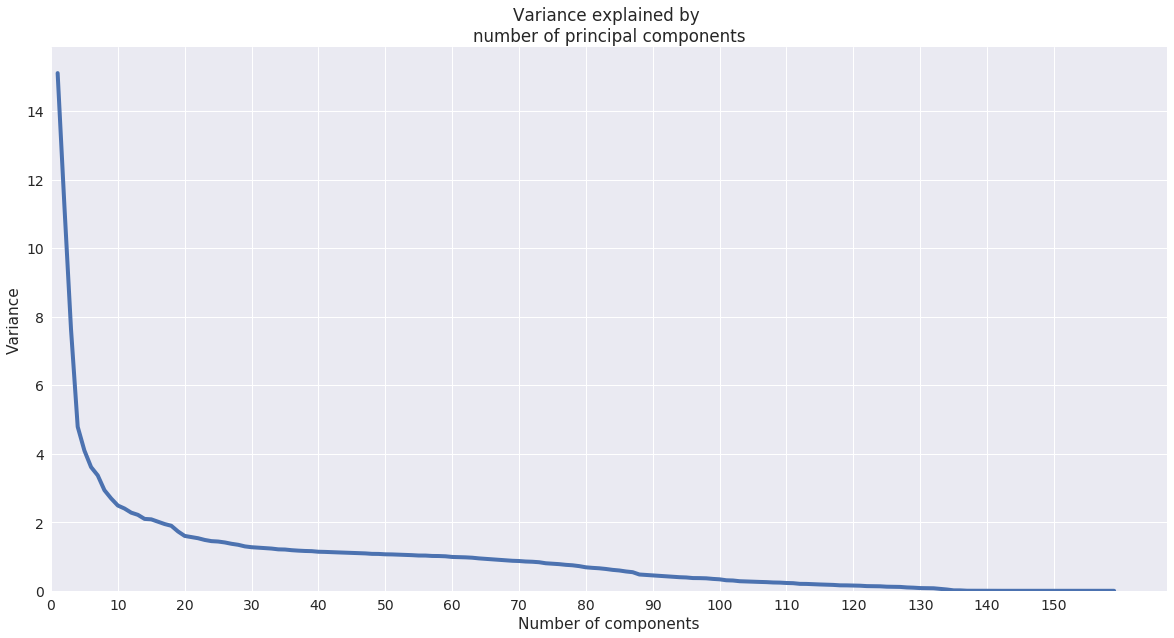

In [74]:
helper_fuctions.plot_variance(prin_comp)

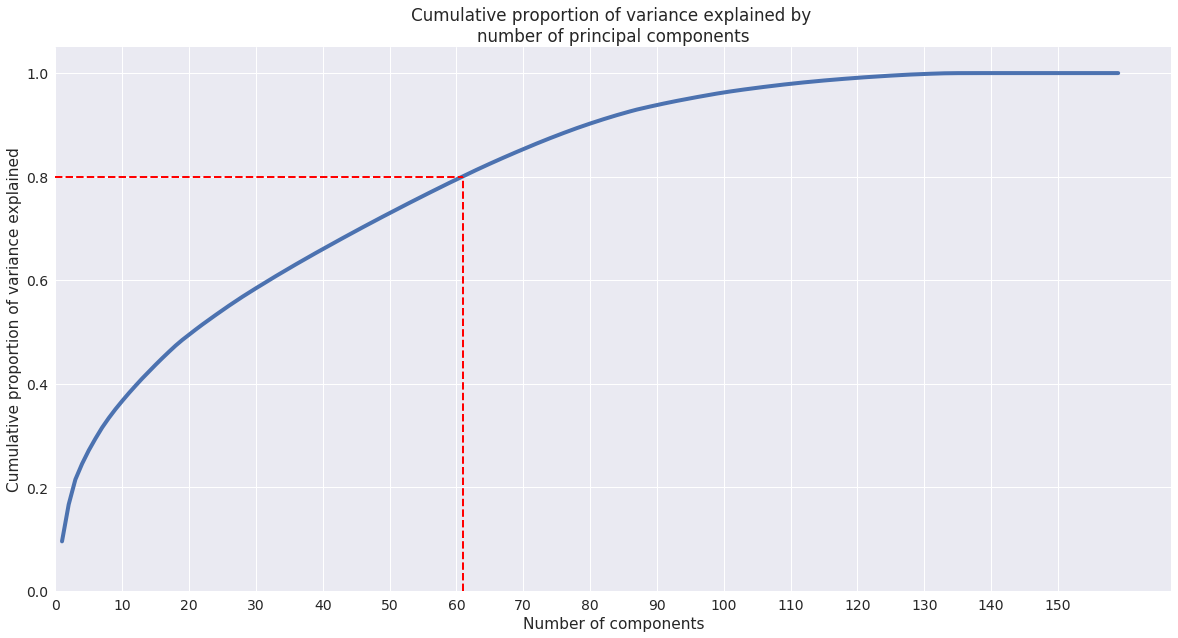

In [75]:
helper_fuctions.plot_variance(prin_comp,True)


In [89]:
# Re-apply PCA to the data while selecting for number of components to retain.
prin_comp = PCA(n_components=20).fit(rescaled_data)

In [91]:
# Saving principle component method as a pickle file
with open('prin_comp.pkl', 'wb') as output: 
    pickle.dump(prin_comp,output)  

In [92]:
reduced_data_pop = prin_comp.transform(rescaled_data)

In [95]:
#Saving reduced dataset as a csv file to be used in case process gets interrupted
np.savetxt("reduced_data.csv", reduced_data_pop, delimiter=",")

In [96]:
input_columns = rescaled_data.columns.tolist()

### Discussion 2.2: Perform Dimensionality Reduction
In deciding on how many principal components to retain in order to effectively summarize the data, the following guidelines have been proposed:

* Retain sufficient components for a specified percentage of the total variance
* Retain the components who eigenvalues are greater than the average of the eigenvalues
* Use the scree plot - a graph of the eigenvalues (variance) versus the number of principal components - and look for the natural break between the 'large' eigenvalues and the 'small' eigenvalues. 

Since the first 2 measures result in too many principal components (61 and 59 respectively), we'll use the scree plot to decide on a cut-off of 20. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

In [106]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

loadings_mapping1 = helper_functions.mapping_principal_components(prin_comp,input_columns,1)

In [107]:
loadings_mapping1.head(10)

,Feature,Loading
94,LP_STATUS_GROB_1.0,0.192908
49,PLZ8_ANTG3,0.186248
26,HH_EINKOMMEN_SCORE,0.180917
58,WEALTH,0.180049
50,PLZ8_ANTG4,0.179940
54,ORTSGR_KLS9,0.162278
39,EWDICHTE,0.160312
6,FINANZ_HAUSBAUER,0.147174
48,PLZ8_ANTG2,0.128530
36,KBA05_ANTG4,0.122373


In [108]:
loadings_mapping1.tail(10)

,Feature,Loading
97,LP_STATUS_GROB_4.0,-0.114261
40,INNENSTADT,-0.133112
52,PLZ8_GBZ,-0.137563
31,KONSUMNAEHE,-0.138240
37,KBA05_GBZ,-0.176318
153,PLZ8_BAUMAX_1.0,-0.178443
33,KBA05_ANTG1,-0.185448
47,PLZ8_ANTG1,-0.186121
1,FINANZ_MINIMALIST,-0.193211
43,MOBI_REGIO,-0.198179


In [109]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
loadings_mapping2 = helper_functions.mapping_principal_components(prin_comp,input_columns,2)
loadings_mapping2.head(10)

,Feature,Loading
0,ALTERSKATEGORIE_GROB,0.226584
3,FINANZ_VORSORGER,0.215223
116,ZABEOTYP_3,0.199933
16,SEMIO_ERL,0.184971
15,SEMIO_LUST,0.158300
9,RETOURTYP_BK_S,0.150863
136,LP_LEBENSPHASE_GROB_2.0,0.149081
27,W_KEIT_KIND_HH,0.114766
63,CJT_GESAMTTYP_2.0,0.106429
6,FINANZ_HAUSBAUER,0.094767


In [110]:
loadings_mapping2.tail(10)

,Feature,Loading
18,SEMIO_RAT,-0.158379
44,ONLINE_AFFINITAET,-0.158398
17,SEMIO_KULT,-0.172173
4,FINANZ_ANLEGER,-0.191777
22,SEMIO_PFLICHT,-0.200350
23,SEMIO_TRADV,-0.203690
5,FINANZ_UNAUFFAELLIGER,-0.212205
12,SEMIO_REL,-0.214859
2,FINANZ_SPARER,-0.219730
56,DECADE,-0.228231


In [111]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
loadings_mapping3 = helper_functions.mapping_principal_components(prin_comp,input_columns,3)
loadings_mapping3.head(10)

,Feature,Loading
60,ANREDE_KZ_1,0.334696
14,SEMIO_VERT,0.307692
10,SEMIO_SOZ,0.241141
11,SEMIO_FAM,0.238551
17,SEMIO_KULT,0.232119
1,FINANZ_MINIMALIST,0.125013
73,FINANZTYP_5,0.123362
104,SHOPPER_TYP_0.0,0.115933
114,ZABEOTYP_1,0.095935
12,SEMIO_REL,0.087134


In [112]:
loadings_mapping3.tail(10)

,Feature,Loading
2,FINANZ_SPARER,-0.065081
106,SHOPPER_TYP_2.0,-0.079638
69,FINANZTYP_1,-0.103538
4,FINANZ_ANLEGER,-0.147516
18,SEMIO_RAT,-0.164803
16,SEMIO_ERL,-0.187235
19,SEMIO_KRIT,-0.249123
20,SEMIO_DOM,-0.272830
21,SEMIO_KAEM,-0.303678
61,ANREDE_KZ_2,-0.334696


### Discussion 2.3: Interpret Principal Components

The first principal component seems to speak to the income level of the person/household. More specifically:
* LP_STATUS_GROB_1.0: Low income earners
* PLZ8_ANTG3: The larger the share of 6-10 family homes in the area, the higher the weight
* HH_EINKOMMEN_SCORE : The lower the estimated household net income, the higher the weight
* EWDICHTE: The higher the density of households per square km, the higher the weight
* FINANZ_HAUSBAUER: The lower the likelihood of home ownership, the higher the weight
* INNENSTADT: The further away from the inner city, the lower the weight.

So this dimension captures low income households in densely populated areas most likely close to the city center.

The second principal component seems to speak to the age and financial secureness of the person/household. More specifically:

* ALTERSKATEGORIE_GROB: The older the person, the higher the weight
* FINANZ_VORSORGER: The lower the 'Be prepared' financial typology, the higher the weight
* SEMIO_ERL: The lower the 'event-oriented' affinity typology, the higher the weight
* LP_LEBENSPHASE_GROB: single low-income and average earners of higher age
* W_KEIT_KIND_HH: The less likely of children in the household, the higher the weight
* FINANZ_HAUSBAUER: The lower the 'home owner' typology, the higher the weight
* FINANZ_SPARER: The lower the 'money-saver' typology, the lower the the weight

So this dimension captures older people in low to average income households. They are less likely to own their homes but are quite diligent  when it comes to saving. 

The third principal component captures the more hedonistic type of person. More specifically:

* ANREDE_KZ: Male
* SEMIO_VERT: The lower the 'dreamful' typology affinity, the higher the weight
* SEMIO_FAM: The lower the 'family minded' typology affinity, the higher the weight
* FINANZTYP: Investor
* SHOPPER_TYP: external supplied hedonists
* ZABEOTYP: Energy consumption typology: green
* SEMIO_REL: The lower the 'Religious' affinity, the higher the weight
* FINANZTYP: low financial interest (MINIMALIST) not associated with this dimension


So this dimension captures hedonistic, non-religious, materialist individuals- most likely men. 


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

Now, it's time to see how the data clusters in the principal components space. In this substep, we will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

In [4]:
# reduced_data_pop = pd.read_csv('reduced_data.csv',header=None )

In [5]:
# scores = np.genfromtxt("scores.csv").tolist()

In [114]:
def get_MSE(data,nclusters):
    
    print('Fitting {} clusters'.format(nclusters))
    scores = np.abs(KMeans(n_clusters=nclusters,random_state=908).fit(data).score(data))
    return scores


scores = []
clusters = range(2,21)

for nclusters in clusters:
    
    scores.append(get_MSE(reduced_data_pop,nclusters))
    np.savetxt("scores.csv", scores, delimiter=",")

    

Fitting 20 clusters


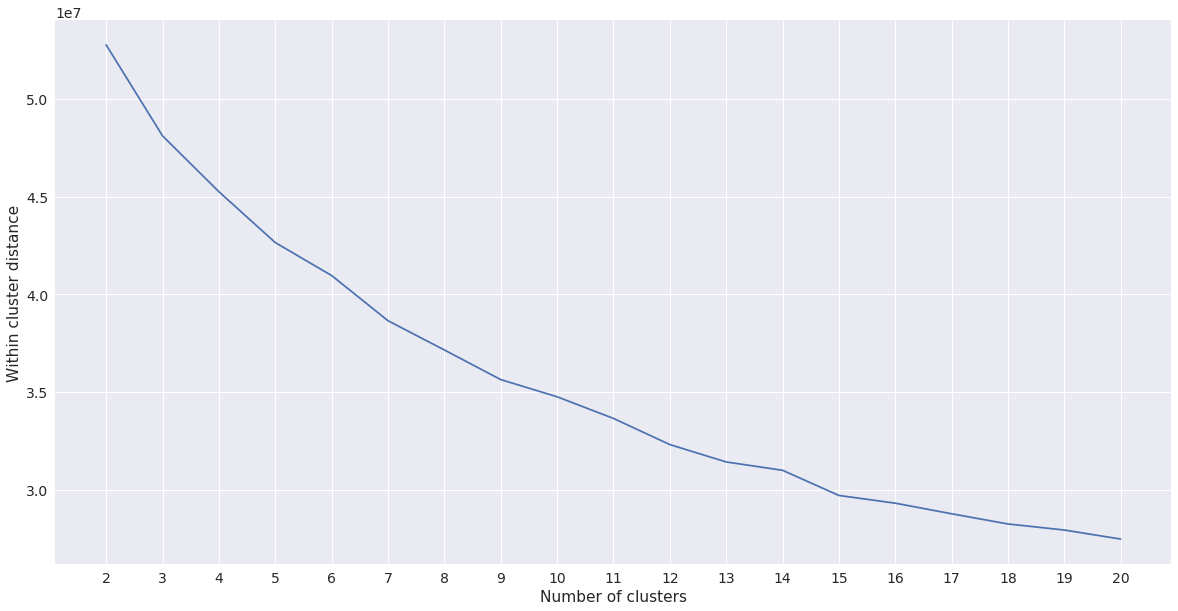

In [118]:
# Investigate the change in within-cluster distance across number of clusters.
plt.figure(figsize=(20,10))
plt.plot(range(2,21),scores)
plt.xlabel('Number of clusters')
plt.ylabel('Within cluster distance')
plt.xticks(range(2,21))
plt.show()

In [119]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans_20 = KMeans(n_clusters=20,random_state=908).fit(reduced_data_pop)

In [121]:
#Saving fitted object to be used in later step
with open('kmeans_20.pkl', 'wb') as output: 
    pickle.dump(kmeans_20,output)  

### Discussion 3.1: Apply Clustering to General Population

Based on the plot of number of clusters vs Within cluster distance, it was decided to keep to 20 clusters. The reduction in the within cluster distance is negligible after around 20 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that we have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters.

In [122]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',delimiter=';')

In [123]:
number_customers, number_customer_col = customers.shape

In [124]:
print('Number of customers: {}'.format(number_customers))
print('Number of fields: {}'.format(number_customer_col))

Number of customers: 191652
Number of fields: 85


In [13]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# with open('categorical_one_hot_enc.pkl', 'rb') as input:
#     categorical_one_hot_enc = pickle.load(input)
    
# with open('prin_comp.pkl', 'rb') as input: 
#     prin_comp = pickle.load(input)
    
# with open('kmeans_20.pkl', 'rb') as input: 
#     kmeans_20 = pickle.load(input)   
    
    
    
# variables_to_be_encoded = ['ANREDE_KZ',
#  'CJT_GESAMTTYP',
#  'FINANZTYP',
#  'GFK_URLAUBERTYP',
#  'LP_FAMILIE_GROB',
#  'LP_STATUS_GROB',
#  'NATIONALITAET_KZ',
#  'SHOPPER_TYP',
#  'SOHO_KZ',
#  'VERS_TYP',
#  'ZABEOTYP',
#  'OST_WEST_KZ',
#  'CAMEO_DEUG_2015',
#  'LP_LEBENSPHASE_GROB',
#  'WOHNLAGE',
#  'PLZ8_BAUMAX']

# drop_variables = ['LP_LEBENSPHASE_FEIN',
#  'CAMEO_INTL_2015',
#  'PRAEGENDE_JUGENDJAHRE',
#  'LP_FAMILIE_FEIN',
#  'LP_STATUS_FEIN',
#  'CAMEO_DEU_2015',
#  'GEBAEUDETYP',
#  'ANREDE_KZ',
#  'CJT_GESAMTTYP',
#  'FINANZTYP',
#  'GFK_URLAUBERTYP',
#  'LP_FAMILIE_GROB',
#  'LP_STATUS_GROB',
#  'NATIONALITAET_KZ',
#  'SHOPPER_TYP',
#  'SOHO_KZ',
#  'VERS_TYP',
#  'ZABEOTYP',
#  'OST_WEST_KZ',
#  'CAMEO_DEUG_2015',
#  'LP_LEBENSPHASE_GROB',
#  'WOHNLAGE',
#  'PLZ8_BAUMAX']


In [125]:
preprocessed_data = helper_functions.clean_data(customers,encoder= categorical_one_hot_enc,
                                                variables_to_be_encoded= variables_to_be_encoded,
                                                drop_variables = drop_variables,
                                                missing_threshold=20)

Encoding Variables
Removing missing values
Creating new variables
One-hot encoding variables


In [126]:
preprocessed_data.shape

(140898, 159)

In [8]:
# means= pd.read_csv('means.csv',header=None,index_col=0).iloc[:,0]
# stdevs = pd.read_csv('stdevs.csv',header=None,index_col=0).iloc[:,0]

In [127]:
rescaled_data = helper_functions.scale_impute_colums(preprocessed_data,means,stdevs)

In [128]:
reduced_data = prin_comp.transform(rescaled_data)

In [129]:
preprocessed_data['cluster'] =  kmeans_20.predict(reduced_data)

In [130]:
preprocessed_data.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,...,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0,PLZ8_BAUMAX_nan,cluster
0,4.0,5,1,5,1,2,2,1,1.0,5.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
2,4.0,5,1,5,1,4,4,1,2.0,5.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2
3,4.0,5,1,5,2,1,2,0,2.0,3.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5
4,3.0,3,1,4,4,5,2,0,3.0,5.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,14
5,3.0,5,1,5,1,2,3,1,3.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0


### Step 3.3: Compare Customer Data to Demographics Data

At this point, we have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, we will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Since we found that the missing value group was qualitatively different from the main bulk of the data, we should treat this as an additional data cluster in this analysis. 

In [131]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

customer_cluster_freq = preprocessed_data['cluster'].value_counts().sort_index()
customer_cluster_perc = customer_cluster_freq/number_customers*100

In [132]:
missing_values_cluster = 100 - customer_cluster_perc.sum()
customer_cluster_perc = pd.DataFrame(customer_cluster_perc.append(pd.Series(missing_values_cluster,index=[20]))
                                     ,columns=['Frequency'])
customer_cluster_perc['Group'] = 'Customers'

In [136]:
reduced_data_pop = pd.read_csv('reduced_data.csv',header=None )
number_obs = 891221

In [137]:
cluster_predictions = kmeans_20.predict(reduced_data_pop)

reduced_data_pop['cluster'] = cluster_predictions

demog_cluster_freq = reduced_data_pop['cluster'].value_counts().sort_index()
demog_cluster_perc = demog_cluster_freq/number_obs*100

missing_values_cluster = 100 - demog_cluster_perc.sum()
demog_cluster_perc = pd.DataFrame(demog_cluster_perc.append(pd.Series(missing_values_cluster,index=[20])),
                                  columns=['Frequency'])
demog_cluster_perc['Group'] = 'Demographics' 

In [138]:
combined = pd.concat([customer_cluster_perc,demog_cluster_perc])

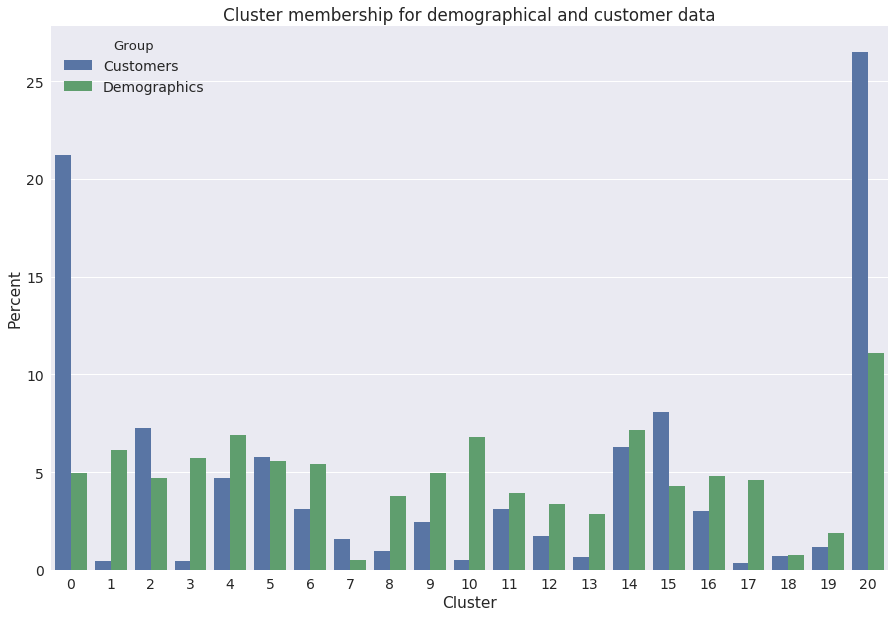

In [139]:
plt.figure(figsize=(15,10))
sns.barplot(x=combined.index, y='Frequency',data=combined,hue='Group')
plt.ylabel('Percent')
plt.xlabel('Cluster')
plt.title('Cluster membership for demographical and customer data')
plt.show()

In [140]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

centroids = preprocessed_data[preprocessed_data['cluster']== 0].mean() 

In [141]:
dummy_vars_to_plot = centroids[dummy_column_names]
integer_vars_to_plot =  centroids[~centroids.index.isin(dummy_vars_to_plot.index)]

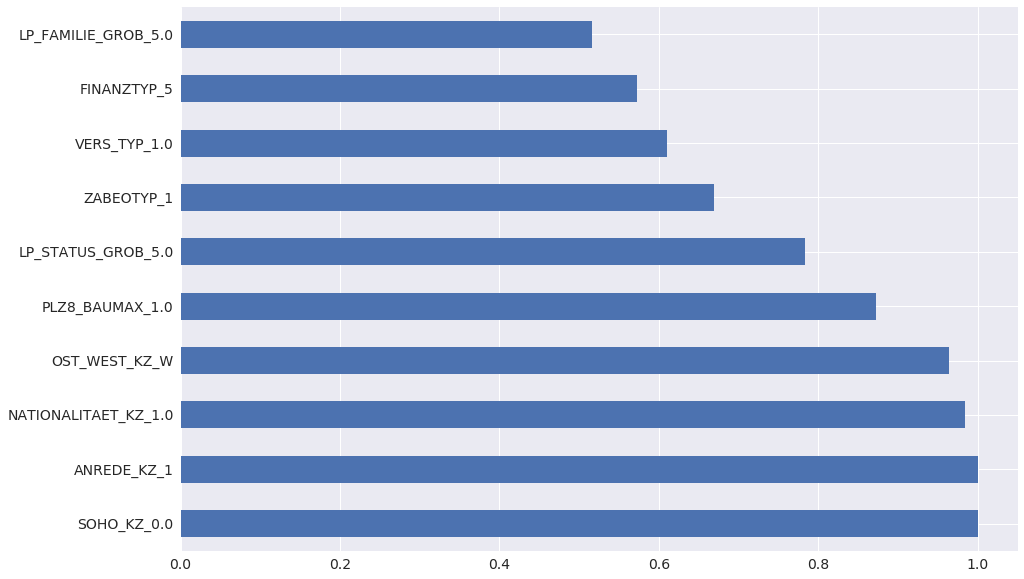

In [142]:
plt.figure(figsize=(15,10))
dummy_vars_to_plot.sort_values(ascending=False)[:10].plot.barh()

In [143]:
for variable, value in integer_vars_to_plot.items():
    print(variable +': {}'.format(value))

ALTERSKATEGORIE_GROB: 3.6653045147949386
FINANZ_MINIMALIST: 4.909321075659997
FINANZ_SPARER: 1.1325647706602429
FINANZ_VORSORGER: 4.838675581338184
FINANZ_ANLEGER: 1.1003637972567721
FINANZ_UNAUFFAELLIGER: 1.74106484440293
FINANZ_HAUSBAUER: 2.1560149451846025
GREEN_AVANTGARDE: 0.9614325746030186
HEALTH_TYP: 1.7843480404239587
RETOURTYP_BK_S: 4.214837028661324
SEMIO_SOZ: 4.932894154662996
SEMIO_FAM: 4.44513544073546
SEMIO_REL: 3.5751929600314636
SEMIO_MAT: 3.9868738016813334
SEMIO_VERT: 6.3845926945577895
SEMIO_LUST: 5.922201465021385
SEMIO_ERL: 3.956590138144634
SEMIO_KULT: 4.8305638857479964
SEMIO_RAT: 2.405461875030726
SEMIO_KRIT: 2.778329482326336
SEMIO_DOM: 3.249864805073497
SEMIO_KAEM: 2.2440637136817267
SEMIO_PFLICHT: 2.7411877488815692
SEMIO_TRADV: 2.972715205742097
ANZ_PERSONEN: 2.502015633449683
ANZ_TITEL: 0.035224423577995184
HH_EINKOMMEN_SCORE: 2.0803795290300378
W_KEIT_KIND_HH: 4.374762662287679
WOHNDAUER_2008: 8.876677646133425
ANZ_HAUSHALTE_AKTIV: 1.4426324253693839
ANZ_H

In [144]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

centroids_109 = preprocessed_data[preprocessed_data['cluster']== 10].mean() 
dummy_vars_to_plot = centroids_10[dummy_column_names]
integer_vars_to_plot =  centroids_10[~centroids_10.index.isin(dummy_vars_to_plot.index)]


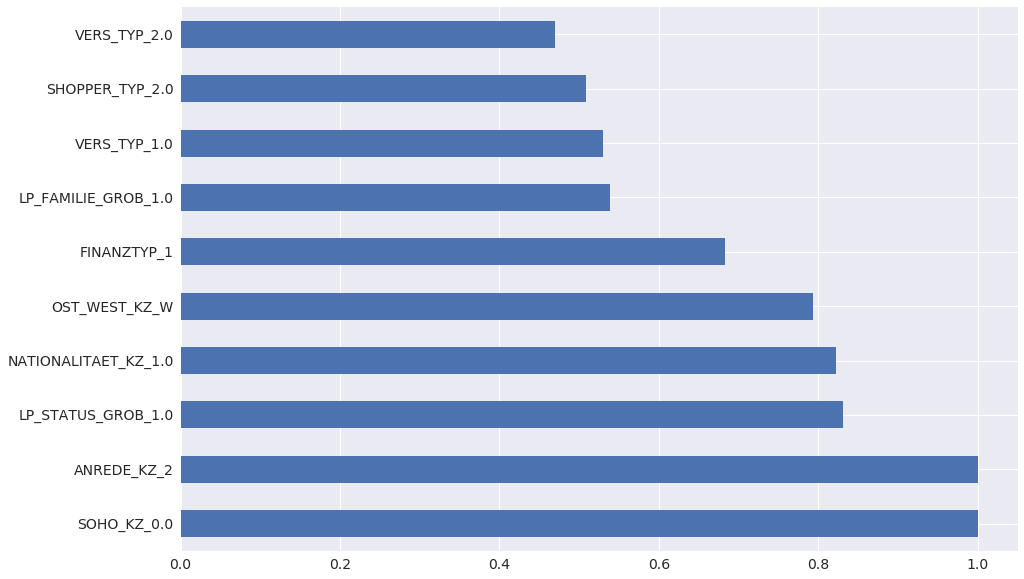

In [145]:
plt.figure(figsize=(15,10))
dummy_vars_to_plot.sort_values(ascending=False)[:10].plot.barh()

In [ ]:
for variable, value in integer_vars_to_plot.items():
    print(variable +': {}'.format(value))

### Discussion 3.3: Compare Customer Data to Demographics Data

From the previous results, we saw that customers of the mail order company falling in cluster 0 was over-represented compared to the general population. This cluster is characterised as follows:

* Mostly german (NATIONALITAET_KZ = 1)
* Mostly residing in West Germany (OST_WEST_KZ = W)
* Living in an area populated mostly with singles and couples (PLZ8_BAUMAX = 1)
* More likely to be top earners (LP_STATUS_GROB = 5)
* More likely to be male (PLZ8_BAUMAX = 1)
* More likely to be an investor (FINANZ_ANLEGER)
* Very high likelihood of being a  member of green avantgarde in their youth (GREEN_AVANTGARDE)
* 50's generation (DECADE)

We also saw that customers of the mail order company falling in cluster 10 was under-represented compared to the general population. This cluster is characterised as follows:

* On average, Very low socially minded and family minded affinity (SEMIO_SOZ & SEMIO_FAM)
* Also culturally minded very low affinity (SEMIO_KULT)
* Lower income household (HH_EINKOMMEN_SCORE)
* Tend to live in quite a dense populated area (EWDICHTE)
* 80's generation (DECADE)
